In [1]:
%matplotlib widget

In [2]:
# Plot error space for one example of case A.2

# Import libraries
import numpy as np
import pygimli as pg
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from sklearn.metrics import root_mean_squared_error
from mpl_toolkits import mplot3d
from joblib import Parallel, delayed
import time
import sys
sys.path.insert(1, '../../src')

# Import functions
from EM1D import EMf_3Lay_HVP, GlobalSearch_3Lay, EMf_3Lay_Opt_HVP_1D

In [3]:
# Load model and data
model_B1_1 = np.load('models/model_synth_B1_1.npy')
model_B1_2 = np.load('models/model_synth_B1_2.npy')
model_B1_3 = np.load('models/model_synth_B1_3.npy')
model_B1_4 = np.load('models/model_synth_B1_4.npy')

data_B1_1 = np.load('data/data_synth_B1_1.npy')
data_B1_2 = np.load('data/data_synth_B1_2.npy')
data_B1_3 = np.load('data/data_synth_B1_3.npy')
data_B1_4 = np.load('data/data_synth_B1_4.npy')

data_B1_1_GS = np.load('data/data_GS_B1_1.npy')

#LUT = np.load('../data/LUTable_3Lay.npy')
conds = np.load('../data/conds.npy')
thicks = np.load('../data/thicks.npy')

# Load survey parameters
survey = np.load('../data/survey_3Lay.npy', allow_pickle=True).item()
offsets = survey['offsets']
height = survey['height']
freq = survey['freq']
lambd = survey['lambd']
filt = survey['filt']

# Load estimated model from Global Search
model_GS_B1_1 = np.load('results/model_GS_B1_1.npy')
model_GS_B1_2 = np.load('results/model_GS_B1_2.npy')
model_GS_B1_3 = np.load('results/model_GS_B1_3.npy')
model_GS_B1_4 = np.load('results/model_GS_B1_4.npy')

# Load estimated models from Optimization
model_Opt_B1_1 = np.load('results/model_Opt_B1_1.npy')
model_Opt_B1_2 = np.load('results/model_Opt_B1_2.npy')
model_Opt_B1_3 = np.load('results/model_Opt_B1_3.npy')
model_Opt_B1_4 = np.load('results/model_Opt_B1_4.npy')

model_Opt_B1_1_hist = np.load('results/model_Opt_B1_1_hist.npy')
model_Opt_B1_2_hist = np.load('results/model_Opt_B1_2_hist.npy')
model_Opt_B1_3_hist = np.load('results/model_Opt_B1_3_hist.npy')
model_Opt_B1_4_hist = np.load('results/model_Opt_B1_4_hist.npy')

# For example let's check the 1D model following position
pos = 10
nsl = len(conds)

model_ini_1 = np.array([3, 3, 100/1000, 100/1000, 100/1000])
model_ini_2 = np.array([3, 3, 200/1000, 200/1000, 200/1000])
model_ini_3 = np.array([3, 3, 400/1000, 400/1000, 400/1000])

In [4]:
model_Opt_B1_3_hist

array([[3.        , 3.        , 0.2       , 0.2       , 0.2       ],
       [3.        , 3.        , 0.15282372, 0.42854768, 0.18202503],
       [2.40124733, 2.93499983, 0.06383383, 0.71938456, 0.11527068],
       [4.01653213, 1.51436853, 0.03636407, 1.35844007, 0.30453263],
       [3.33091517, 1.51396371, 0.02848777, 1.03206481, 0.17713048],
       [3.2994668 , 1.51398185, 0.02518313, 1.11743639, 0.12509473],
       [3.22664473, 1.51400094, 0.02087242, 1.18948509, 0.07415984],
       [3.20311125, 1.51398884, 0.01993296, 1.16587124, 0.07202068],
       [3.10568909, 5.5       , 0.02005318, 0.88947149, 0.05424695]])

In [5]:
model_Opt_B1_3[10]

array([3.10568909, 5.5       , 0.02005318, 0.88947149, 0.05424695])

In [6]:
def nrmse(obs, pred):
    
    nrse = root_mean_squared_error(obs, pred)/np.abs(np.max(obs)-np.min(obs))
    return nrse
    
def NoiseAnalysis_GS_2Lay(data_true, noise=0.1, test_it=100):
    
    models_GS = []
    for i in range(test_it):
        data_noise = data_true* (1 +np.random.normal(size=len(data_true))*noise)
        models_GS.append(GlobalSearch_2Lay(LUT, data_noise, conds, thicks, nsl))
    return models_GS 

def NoiseAnalysis_Opt_3Lay(data_true, noise=0.1, test_it=100):
    m0 = [3, 3, 100/1000, 100/1000, 100/1000]
    lam = 0
    models_Opt = []
    
    transThk = pg.trans.TransLogLU(1,4)
    transSig = pg.trans.TransLogLU(10/1000,2000/1000)
    
    for i in range(test_it):
        EMf = EMf_3Lay_Opt_HVP_1D(lambd, height, offsets, freq, filt, nlay=3)
        
        # Define transformation
        EMf.region(0).setTransModel(transThk)
        EMf.region(1).setTransModel(transSig)

        # Define inversion framework from pygimli
        invEM = pg.Inversion()
        invEM.setForwardOperator(EMf) # set forward operator

        # Relative error array
        error = 1e-3 # relative error
        relativeError = np.ones_like(data_true[0]) * error
        data_noise = data_true* (1 +np.random.normal(size=len(data_true))*noise)
        models_Opt.append(invEM.run(data_noise, relativeError, startModel= m0, lam=lam, verbose=False))
    return models_Opt


In [7]:
def m0_Analysis_Opt_3Lay(sigma, data_true):
    m0 = [3, 3, sigma/1000, sigma/1000, sigma/1000]
    lam = 0
    models_Opt = []
    
    transThk = pg.trans.TransLogLU(np.min(thicks),np.max(thicks))
    transSig = pg.trans.TransLogLU(np.min(conds),np.max(conds))
    
    EMf = EMf_3Lay_Opt_HVP_1D(lambd, height, offsets, freq, filt, nlay=3)

    # Define transformation
    EMf.region(0).setTransModel(transThk)
    EMf.region(1).setTransModel(transSig)

    # Define inversion framework from pygimli
    invEM = pg.Inversion()
    invEM.setForwardOperator(EMf) # set forward operator

    # Relative error array
    error = 1e-3 # relative error
    relativeError = np.ones_like(data_true[0]) * error
    model_Opt = invEM.run(data_true, relativeError, startModel= m0, lam=lam, verbose=False)
    return model_Opt

In [8]:
sigmas = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

In [9]:
models_m0_B1_1 = []
models_m0_B1_2 = []
models_m0_B1_3 = []
models_m0_B1_4 = []

for sigma in sigmas:
    models_m0_B1_1.append(m0_Analysis_Opt_3Lay(sigma, data_B1_1[pos]))
    models_m0_B1_2.append(m0_Analysis_Opt_3Lay(sigma, data_B1_2[pos]))
    models_m0_B1_3.append(m0_Analysis_Opt_3Lay(sigma, data_B1_3[pos]))
    models_m0_B1_4.append(m0_Analysis_Opt_3Lay(sigma, data_B1_4[pos]))
    
models_m0_B1_1 = np.array(models_m0_B1_1)
models_m0_B1_2 = np.array(models_m0_B1_2)
models_m0_B1_3 = np.array(models_m0_B1_3)
models_m0_B1_4 = np.array(models_m0_B1_4)

In [10]:
# Plot

def PlotModel(model, depths, ax=None, model_name=None, model_style='k', ylab=False, xlab=False, lw=1):
    if ax is None:
        fig, ax = plt.subplots()
    fs=7
    ax.step(model, depths, color=model_style, label=model_name, linewidth=lw)
    ax.set_xscale('log')
    if xlab == True:
        ax.set_xlabel('Electrical conductivity [mS/m]', fontsize=fs)
    if ylab == True:
        ax.set_ylabel('Depth [m]', fontsize=fs)
    if model_name is not None:
        ax.legend(fontsize=fs, bbox_to_anchor=(1.1, 1.05))
    ax.tick_params(labelsize=fs)
    plt.tight_layout()

    
def Plot_m0(models_m0, model_true, dmax=-10, ax=None, ylab=False, xlab=False, legend=False):
    if ax is None:
        fig, ax = plt.subplots()
    fs=7
    
    for m in range(len(models_m0)):
        color = (0.1*m, 0.5, 0.5)
        mod = models_m0[m]
        sigma_2Lay_plot = np.hstack((mod[2:], mod[-1]))
        depths_2Lay_plot = np.hstack([0, -mod[0], -np.sum(mod[:2]), dmax])
        data = EMf_3Lay_HVP(lambd, mod[2], mod[3], mod[4], mod[0], mod[1],
                            height, offsets, freq, filt)
        data_true = EMf_3Lay_HVP(lambd, model_true[2], model_true[3], model_true[4], model_true[0], model_true[1],
                                 height, offsets, freq, filt)
        rmse = nrmse(data_true, data)
        if legend == True:
            PlotModel(sigma_2Lay_plot, depths_2Lay_plot, ax=ax, model_style=color, model_name='$m_0: $' 
                      + str(sigmas[m]) + ' mS/m' + ', nrmse: ' + '%.2f' %rmse)
        else:
            PlotModel(sigma_2Lay_plot, depths_2Lay_plot, ax=ax, model_style=color, )
    sigma_true = np.hstack((model_true[2:], model_true[-1]))
    depth_true = np.hstack([0, -model_true[0], -np.sum(model_true[:2]), dmax])
    if legend == True:
        PlotModel(sigma_true, depth_true, model_name='True', ax=ax, lw = 2)
    else:
        PlotModel(sigma_true, depth_true, ax=ax, lw=2)
    
 #   sigma_est = np.hstack((model_est[1:], model_est[-1]))
 #   depth_est = np.array([0, -model_est[0], dmax])
 #   PlotModel(sigma_est, depth_est, model_name='Est', ax=ax, model_style='r', ylab=ylab, xlab=xlab)

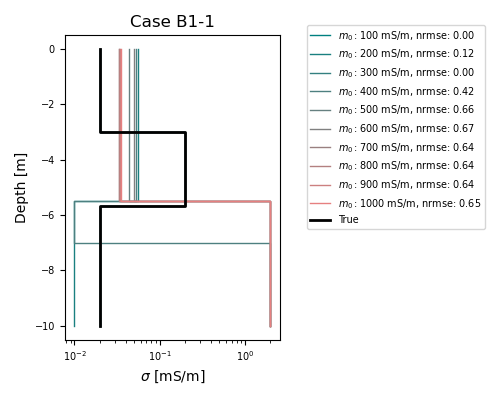

In [11]:
fig, ax = plt.subplots(figsize=(5,4))

Plot_m0(models_m0_B1_1, model_B1_1[pos], ax=ax, legend=True)

ax.set_title('Case B1-1')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('$\sigma$ [mS/m]')

plt.tight_layout()

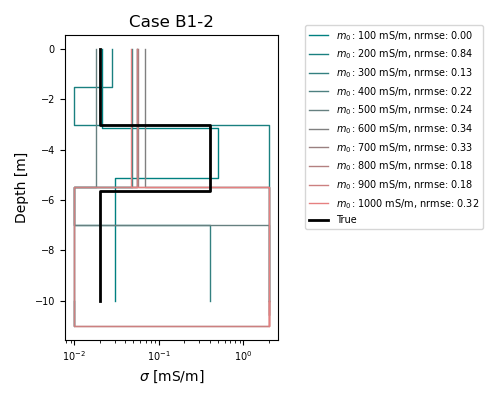

In [12]:
fig, ax = plt.subplots(figsize=(5,4))

Plot_m0(models_m0_B1_2, model_B1_2[pos], ax=ax, legend=True)

ax.set_title('Case B1-2')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('$\sigma$ [mS/m]')

plt.tight_layout()

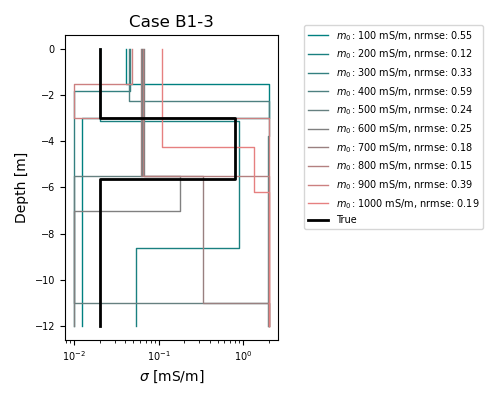

In [13]:
fig, ax = plt.subplots(figsize=(5,4))

Plot_m0(models_m0_B1_3, model_B1_3[pos], ax=ax, legend=True, dmax=-12)

ax.set_title('Case B1-3')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('$\sigma$ [mS/m]')

plt.tight_layout()

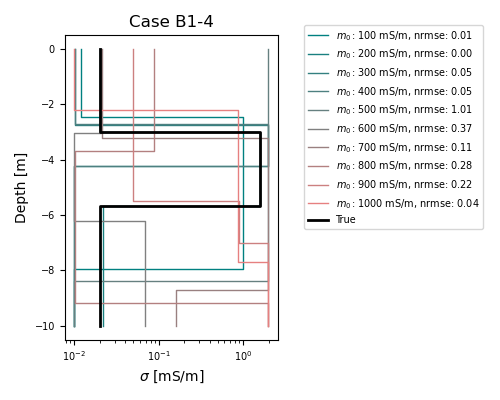

In [14]:
fig, ax = plt.subplots(figsize=(5,4))

Plot_m0(models_m0_B1_4, model_B1_4[pos], ax=ax, legend=True)

ax.set_title('Case B1-4')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('$\sigma$ [mS/m]')

plt.tight_layout()

In [15]:


def Error_analysis(model_est, model_true, data_true, pos, thicks, conds, max_err=0.1):
    """ change later rmse"""
    err = []
    models_err = []

    for h1 in thicks:
        for h2 in thicks:
            for sigma2 in conds:
                for sigma3 in conds:
                    mod = [h1, h2, model_true[pos,2], sigma2, sigma3]
                   # h1 = model_true[pos,0]
                    sigma1 = model_true[pos,2]
                  #  sigma3 = model_true[pos,4]
                    dat = EMf_3Lay_HVP(lambd, sigma1, sigma2, sigma3, h1, h2, height, offsets, freq, filt)
                    nrse = nrmse(data_true[pos], dat)
    
                    if nrse < max_err:
                        err.append(nrse)    
                        models_err.append(mod)

    err = np.array(err)
    models_err = np.array(models_err)

    return err, models_err

def Error_analysis_v2(model_est, model_true, data_true, pos, thicks, conds, max_err=0.1):
    """ change later rmse"""
    err = []
    models_err = []

    for h2 in thicks:
        for sigma2 in conds:
            for sigma3 in conds:
                mod = [model_true[pos,0], h2, model_true[pos,2], sigma2, sigma3]
                h1 = model_true[pos,0]
                sigma1 = model_true[pos,2]
              #  sigma3 = model_true[pos,4]
                dat = EMf_3Lay_HVP(lambd, sigma1, sigma2, sigma3, h1, h2, height, offsets, freq, filt)
                nrse = nrmse(data_true[pos], dat)

                if nrse < max_err:
                    err.append(nrse)    
                    models_err.append(mod)

    err = np.array(err)
    models_err = np.array(models_err)

    return err, models_err

def Error_analysis_parallel(data_true, max_err, h1, h2, s1, s2, s3):
    """ change later rmse"""

    mod = [h1, h2, s1, s2, s3]
    dat = EMf_3Lay_HVP(lambd, s1, s2, s3, h1, h2, height, offsets, freq, filt)
    nrse = nrmse(data_true, dat)

    if nrse < max_err:
        model_err = np.hstack((mod, nrse))
        return model_err

def Error_analysis(data_true, max_err, model_true):
    """ change later rmse"""

    err = []
    models = []
    pos = len(model_true)
    
    for p in range(pos):
        mod = model_true[p]
        h1 = mod[0]
        h2 = mod[1]
        s1 = mod[2]
        s2 = mod[3]
        s3 = mod[4]
        dat = EMf_3Lay_HVP(lambd, s1, s2, s3, h1, h2, height, offsets, freq, filt)
        nrse = nrmse(data_true, dat)
    
        if nrse < max_err:
            err.append(nrse)
            models.append(mod)

    return np.array(err), np.array(models)

In [7]:
# Analyze error space

n_workers = 40
max_err = 0.1 # Testing larger noise
print('Start calculating error ...')
startTime = time.time()

models_err_B1_1 = Parallel(n_jobs=n_workers,verbose=0)(delayed(Error_analysis_parallel)(data_B1_1[pos], max_err, h1, h2, s1, s2, s3)
                                           for h1 in thicks for h2 in thicks for s1 in conds for s2 in conds for s3 in conds)

executionTime = ((time.time() - startTime))/60
print('Execution time in seconds: ', f"{executionTime:.3}", ' minutes')

Start calculating error ...
Execution time in seconds:  2.14e+02  minutes


In [8]:
mod_err = [i for i in models_err_B1_1 if i is not None]
models_err_B1_1_snip = np.array(mod_err)
err_B1_1_snip = models_err_B1_1_snip[:,-1]
models_err_B1_1_snip = models_err_B1_1_snip[:,:5]

np.save('results/models_err_B1_1', models_err_B1_1_snip)
np.save('results/err_B1_1', err_B1_1_snip)


NameError: name 'models_err_B1_1' is not defined

In [6]:
# Analyze error space

n_workers = 40
max_err = 0.1 # Testing larger noise
print('Start calculating error ...')
startTime = time.time()

models_err_B1_2 = Parallel(n_jobs=n_workers,verbose=0)(delayed(Error_analysis_parallel)(data_B1_2[pos], max_err, h1, h2, s1, s2, s3)
                                           for h1 in thicks for h2 in thicks for s1 in conds for s2 in conds for s3 in conds)

executionTime = ((time.time() - startTime))/60
print('Execution time in seconds: ', f"{executionTime:.3}", ' minutes')

Start calculating error ...
Execution time in seconds:  1.25e+02  minutes


In [7]:
mod_err = [i for i in models_err_B1_2 if i is not None]
models_err_B1_2_snip = np.array(mod_err)
err_B1_2_snip = models_err_B1_2_snip[:,-1]
models_err_B1_2_snip = models_err_B1_2_snip[:,:5]

np.save('results/models_err_B1_2', models_err_B1_2_snip)
np.save('results/err_B1_2', err_B1_2_snip)

In [32]:
# Analyze error space

n_workers = 40
max_err = 0.1 # Testing larger noise
print('Start calculating error ...')
startTime = time.time()

models_err_B1_3 = Parallel(n_jobs=n_workers,verbose=0)(delayed(Error_analysis_parallel)(data_B1_3[pos], max_err, h1, h2, s1, s2, s3)
                                           for h1 in thicks for h2 in thicks for s1 in conds for s2 in conds for s3 in conds)

executionTime = ((time.time() - startTime))/60
print('Execution time in seconds: ', f"{executionTime:.3}", ' minutes')

Start calculating error ...
Execution time in seconds:  1.38e+02  minutes


In [33]:
mod_err = [i for i in models_err_B1_3 if i is not None]
models_err_B1_3_snip = np.array(mod_err)
err_B1_3_snip = models_err_B1_3_snip[:,-1]
models_err_B1_3_snip = models_err_B1_3_snip[:,:5]

np.save('results/models_err_B1_3', models_err_B1_3_snip)
np.save('results/err_B1_3', err_B1_3_snip)

In [6]:
# Analyze error space

n_workers = 40
max_err = 0.1 # Testing larger noise
print('Start calculating error ...')
startTime = time.time()

models_err_B1_4 = Parallel(n_jobs=n_workers,verbose=0)(delayed(Error_analysis_parallel)(data_B1_4[pos], max_err, h1, h2, s1, s2, s3)
                                           for h1 in thicks for h2 in thicks for s1 in conds for s2 in conds for s3 in conds)

executionTime = ((time.time() - startTime))/60
print('Execution time in seconds: ', f"{executionTime:.3}", ' minutes')

Start calculating error ...
Execution time in seconds:  1.55e+02  minutes


In [7]:
mod_err = [i for i in models_err_B1_4 if i is not None]
models_err_B1_4_snip = np.array(mod_err)
err_B1_4_snip = models_err_B1_4_snip[:,-1]
models_err_B1_4_snip = models_err_B1_4_snip[:,:5]

np.save('results/models_err_B1_4', models_err_B1_4_snip)
np.save('results/err_B1_4', err_B1_4_snip)

In [8]:
# Load error models

In [16]:
models_err_B1_1 = np.load('results/models_err_B1_1_0.3.npy')
err_B1_1 = np.load('results/err_B1_1_0.3.npy')

models_err_B1_2 = np.load('results/models_err_B1_2_0.3.npy')
err_B1_2 = np.load('results/err_B1_2_0.3.npy')

models_err_B1_3 = np.load('results/models_err_B1_3_0.3.npy')
err_B1_3 = np.load('results/err_B1_3_0.3.npy')

models_err_B1_4 = np.load('results/models_err_B1_4_0.3.npy')
err_B1_4 = np.load('results/err_B1_4_0.3.npy')

In [7]:
# Add to the error space the error with respect to true model

err_B1_1_true, models_err_B1_1_true = Error_analysis(data_B1_1[pos], 0.3, model_B1_1)
err_B1_1 = np.hstack((err_B1_1, err_B1_1_true))
models_err_B1_1 = np.vstack((models_err_B1_1, models_err_B1_1_true))

err_B1_2_true, models_err_B1_2_true = Error_analysis(data_B1_2[pos], 0.3, model_B1_2)
err_B1_2 = np.hstack((err_B1_2, err_B1_2_true))
models_err_B1_2 = np.vstack((models_err_B1_2, models_err_B1_2_true))

err_B1_3_true, models_err_B1_3_true = Error_analysis(data_B1_3[pos], 0.3, model_B1_3)
err_B1_3 = np.hstack((err_B1_3, err_B1_3_true))
models_err_B1_3 = np.vstack((models_err_B1_3, models_err_B1_3_true))

err_B1_4_true, models_err_B1_4_true = Error_analysis(data_B1_4[pos], 0.3, model_B1_4)
err_B1_4 = np.hstack((err_B1_4, err_B1_4_true))
models_err_B1_4 = np.vstack((models_err_B1_4, models_err_B1_4_true))

In [21]:
# Plot error space

In [17]:
def PlotErrorSpace(ax1, ax2, model, model_est, model_opt, model_ini, model_hist,
                   err, models_err, xmin, xmax, ymin, ymax, case='', method='', depthmax=-10, colorbar=False):
    # Arrays to plot
    depth_true = np.array([0, -model[0], -np.sum(model[:2]), depthmax])
    depth_est = np.array([0, -model_est[0], -np.sum(model_est[:2]), depthmax])
    depth_opt = np.array([0, -model_opt[0], -np.sum(model_opt[:2]), depthmax])
    depth_ini = np.array([0, -model_ini[0], -np.sum(model_ini[:2]), depthmax])

    sigma_true = np.hstack([model[2:], model[-1]])
    sigma_est = np.hstack([model_est[2:], model_est[-1]])
    sigma_opt = np.hstack([model_opt[2:], model_opt[-1]])
    sigma_ini = np.hstack([model_ini[2:], model_ini[-1]])

 #   for i in range(len(model_hist)):
 #       depth = np.array([0, -model_hist[i,0], -np.sum(model_hist[i,:2]), depthmax])
 #       sigmas = np.hstack([model_hist[i,2:], model_hist[i,-1]])
 #       ax1.step(sigmas*1000, depth, ':k',)
       
  #  fig, ax = plt.subplots(1,2, figsize=(6,4), gridspec_kw={'width_ratios': [1,1.5]})
    
    ax1.step(sigma_true*1000, depth_true, 'k', label = 'True', linewidth=4)
    ax1.step(sigma_est*1000, depth_est, 'r', label='GS')
    ax1.step(sigma_opt*1000, depth_opt, 'c', label='GI')
    ax1.step(sigma_ini*1000, depth_ini, 'g', label='Initial')
    ax1.set_xlim([1,2500])
    ax1.set_ylabel('Depth [m]', fontsize=8)
    ax1.set_xlabel('$\sigma$ [mS/m]', fontsize=8)
    ax1.set_title('1D Model position: ' +str(pos) + ' - Case: '+case, fontsize=8)
    ax1.set_xscale('log')
    ax1.legend(bbox_to_anchor=(1.1, 1.05), fontsize=7)

    x = models_err[:,3]*1000 # conductivities of second layer in mS/m
    y = models_err[:,0]          # thickness of second layer
    z = err

    ngridx = 100
    ngridy = 200
    
    # Create grid values first.
    xi = np.linspace(np.min(x), np.max(x), ngridx)
    yi = np.linspace(np.min(y), np.max(y), ngridy)

    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)

    ax2.contour(xi, yi, zi*100, levels=15, linewidths=0.5, colors='k', )
    cntr1 = ax2.contourf(xi, yi, zi*100, levels=15, cmap="RdBu_r", vmin=0, vmax=30)
    #ax2.plot(x, y, '.k', ms=1)
    ax2.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    ax2.scatter(model[3]*1000, model[0], marker='o', c='w', label='True model',)
    ax2.scatter(model_est[3]*1000, model_est[0], marker ='x', c='y', label='GS', )
    ax2.scatter(model_opt[3]*1000, model_opt[0], marker ='x', c='c', label='GI', )
    ax2.scatter(model_ini[3]*1000, model_ini[0], marker ='x', c='g', label='Initial', )

    for i in range(len(model_hist)):
        ax2.scatter(((model_hist[i,3])*1000), model_hist[i,0], marker ='.', c='k',)
        if i >= 1:
            m1 = model_hist[i-1]
            m2 = model_hist[i]
            x = model_hist[i-1:i+1,3]*1000
            y = model_hist[i-1:i+1,0]
            ax2.plot(x,y, ':k')
    
    ax2.set_xlabel('$\sigma_2$ [mS/m]', fontsize=8)
    ax2.set_ylabel('$h_2$ [m]', fontsize=8)
    ax2.legend(fontsize=7)
    ax2.tick_params(axis='both',labelsize=9)
    ax1.tick_params(axis='both',labelsize=9)
    ax2.set_title(method, fontsize=8)
    
    if colorbar==True:
        clb = fig.colorbar(cntr1, ax=ax2, ticks=[0, 5,10, 15, 20, 25, 30])
        clb.ax.set_title('NRMSE %', fontsize=7)
        clb.ax.tick_params(labelsize=9)



In [48]:
def PlotModel2(ax1, model, model_est, model_opt, model_ini, model_hist,
                  case='', method='', depthmax=-8, colorbar=False):
    # Arrays to plot
    depth_true = np.array([0, -model[0], -np.sum(model[:2]), depthmax])
    depth_est = np.array([0, -model_est[0], -np.sum(model_est[:2]), depthmax])
    depth_opt = np.array([0, -model_opt[0], -np.sum(model_opt[:2]), depthmax])
    depth_ini = np.array([0, -model_ini[0], -np.sum(model_ini[:2]), depthmax])

    sigma_true = np.hstack([model[2:], model[-1]])
    sigma_est = np.hstack([model_est[2:], model_est[-1]])
    sigma_opt = np.hstack([model_opt[2:], model_opt[-1]])
    sigma_ini = np.hstack([model_ini[2:], model_ini[-1]])

 #   for i in range(len(model_hist)):
 #       depth = np.array([0, -model_hist[i,0], -np.sum(model_hist[i,:2]), depthmax])
 #       sigmas = np.hstack([model_hist[i,2:], model_hist[i,-1]])
 #       ax1.step(sigmas*1000, depth, ':k',)
       
  #  fig, ax = plt.subplots(1,2, figsize=(6,4), gridspec_kw={'width_ratios': [1,1.5]})
    
    ax1.step(sigma_true*1000, depth_true, 'k', label = 'True', linewidth=4)
    ax1.step(sigma_est*1000, depth_est, 'r', label='GS')
    ax1.step(sigma_opt*1000, depth_opt, 'c', label='GN')
    ax1.step(sigma_ini*1000, depth_ini, 'g', label='Initial')
    ax1.set_xlim([5,2500])
    ax1.set_ylabel('Depth [m]', fontsize=8)
    ax1.set_xlabel('$\sigma$ [mS/m]', fontsize=8)
    ax1.set_title('1D Model X=' +str(pos) + 'm - Case: '+case, fontsize=8)
    ax1.set_xscale('log')
    ax1.legend(bbox_to_anchor=(1.1, 1.05), fontsize=7)
    ax1.tick_params(axis='both',labelsize=9)

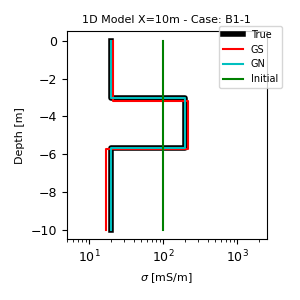

In [49]:
fig, ax = plt.subplots(figsize=(3,3))

PlotModel2(ax, model_B1_1[pos], model_GS_B1_1[pos], model_Opt_B1_1[pos], model_ini_1, 
               model_Opt_B1_1_hist, 
               case='B1-1', depthmax=-10)

plt.tight_layout()

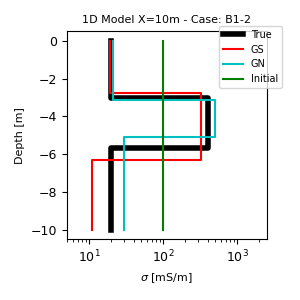

In [50]:
fig, ax = plt.subplots(figsize=(3,3))

PlotModel2(ax, model_B1_2[pos], model_GS_B1_2[pos], model_Opt_B1_2[pos], model_ini_1, 
               model_Opt_B1_2_hist, 
               case='B1-2', depthmax=-10)

plt.tight_layout()

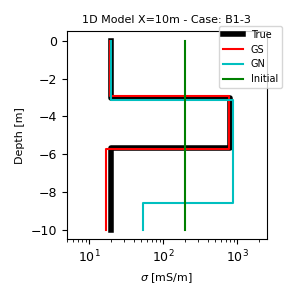

In [51]:
fig, ax = plt.subplots(figsize=(3,3))

PlotModel2(ax, model_B1_3[pos], model_GS_B1_3[pos], model_Opt_B1_3[pos], model_ini_2, 
               model_Opt_B1_3_hist, 
               case='B1-3', depthmax=-10)

plt.tight_layout()

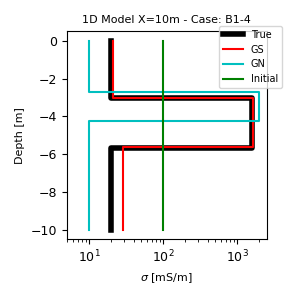

In [52]:
fig, ax = plt.subplots(figsize=(3,3))

PlotModel2(ax, model_B1_4[pos], model_GS_B1_4[pos], model_Opt_B1_4[pos], model_ini_1, 
               model_Opt_B1_4_hist, 
               case='B1-4', depthmax=-10)

plt.tight_layout()

In [15]:
# in 3D

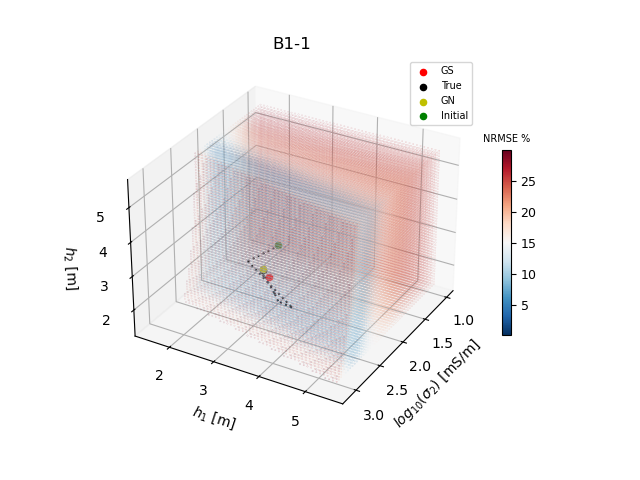

In [20]:
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')

models_err_B1_1_sn = models_err_B1_1.copy()
err_B1_1_sn = err_B1_1.copy()

#index_h1 = (models_err_B1_1_sn[:,0] == model_GS_B1_1[pos,0]) + (models_err_B1_1_sn[:,0] == model_B1_1[pos,0])
#models_err_B1_1_sn = models_err_B1_1_sn[np.where(index_h1)[0]]
#err_B1_1_sn = err_B1_1_sn[np.where(index_h1)[0]]

index_s2 = (models_err_B1_1_sn[:,2] == model_GS_B1_1[pos,2]) + (models_err_B1_1_sn[:,2] == model_B1_1[pos,2])
models_err_B1_1_sn = models_err_B1_1_sn[np.where(index_s2)[0]]
err_B1_1_sn = err_B1_1_sn[np.where(index_s2)[0]]

index_s3 = (models_err_B1_1_sn[:,4] == model_GS_B1_1[pos,4])
models_err_B1_1_sn = models_err_B1_1_sn[np.where(index_s3)[0]]
err_B1_1_sn = err_B1_1_sn[np.where(index_s3)[0]]
 
# defining axes
z = models_err_B1_1_sn[:,1] # h2
x = np.log10(models_err_B1_1_sn[:,3]*1000) # s2
y = models_err_B1_1_sn[:,0] # h1
c = err_B1_1_sn*100
cb = ax.scatter(x, y, z, c = c, s= 0.01, cmap="RdBu_r")
ax.scatter(np.log10(model_GS_B1_1[pos,3]*1000), model_GS_B1_1[pos,0], model_GS_B1_1[pos,1], c='r', s=20, label='GS')
ax.scatter(np.log10(model_B1_1[pos,3]*1000), model_B1_1[pos,0], model_B1_1[pos,1], c='k', s=20, label='True')
ax.scatter(np.log10(model_Opt_B1_1[pos,3]*1000), model_Opt_B1_1[pos,0], model_Opt_B1_1[pos,1], c='y', s=20, label='GN')
ax.scatter(np.log10(model_ini_1[3]*1000), model_ini_1[0], model_ini_1[1], c='g', s=20, label='Initial')
ax.legend(fontsize=7)
for i in range(len(model_Opt_B1_1_hist)):
    if i >= 1:
        m1 = model_Opt_B1_1_hist[i-1]
        m2 = model_Opt_B1_1_hist[i]
        x = np.log10(model_Opt_B1_1_hist[i-1:i+1,3]*1000)
        y = model_Opt_B1_1_hist[i-1:i+1,0]
        z = model_Opt_B1_1_hist[i-1:i+1,1]
        ax.plot(x,y,z, ':k')
ax.view_init(30, 30,0)
ax.set_xlabel('$log_{10}$($\sigma_2$) [mS/m]')
ax.set_ylabel('$h_1$ [m]')
ax.set_zlabel('$h_2$ [m]')
# syntax for plotting
ax.set_title('B1-1')

clb = fig.colorbar(cb, ax=ax, ticks=[0, 5,10, 15, 20, 25, 30], shrink=0.5)
clb.ax.set_title('NRMSE %', fontsize=7)
clb.ax.tick_params(labelsize=9)
plt.show()
plt.tight_layout()



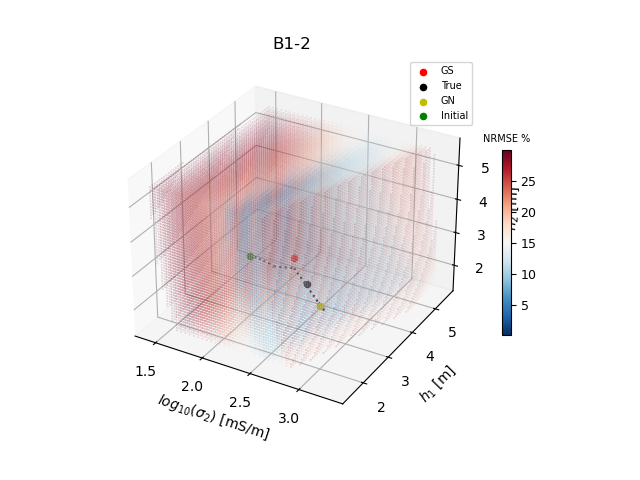

In [21]:
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')

models_err_B1_2_sn = models_err_B1_2.copy()
err_B1_2_sn = err_B1_2.copy()

#index_h1 = (models_err_B1_2_sn[:,0] == model_GS_B1_2[pos,0]) + (models_err_B1_2_sn[:,0] == model_B1_2[pos,0])
#models_err_B1_2_sn = models_err_B1_2_sn[np.where(index_h1)[0]]
#err_B1_2_sn = err_B1_2_sn[np.where(index_h1)[0]]

index_s2 = (models_err_B1_2_sn[:,2] == model_GS_B1_2[pos,2]) + (models_err_B1_2_sn[:,2] == model_B1_2[pos,2])
models_err_B1_2_sn = models_err_B1_2_sn[np.where(index_s2)[0]]
err_B1_2_sn = err_B1_2_sn[np.where(index_s2)[0]]

index_s3 = (models_err_B1_2_sn[:,4] == model_GS_B1_2[pos,4])
models_err_B1_2_sn = models_err_B1_2_sn[np.where(index_s3)[0]]
err_B1_2_sn = err_B1_2_sn[np.where(index_s3)[0]]
 
# defining axes
z = models_err_B1_2_sn[:,1] # h2
x = np.log10(models_err_B1_2_sn[:,3]*1000) # s2
y = models_err_B1_2_sn[:,0] # h1
c = err_B1_2_sn*100
ax.scatter(x, y, z, c = c, s= 0.01, cmap="RdBu_r", )
ax.scatter(np.log10(model_GS_B1_2[pos,3]*1000), model_GS_B1_2[pos,0], model_GS_B1_2[pos,1], c='r', s=20, label ='GS')
ax.scatter(np.log10(model_B1_2[pos,3]*1000), model_B1_2[pos,0], model_B1_2[pos,1], c='k', s=20, label='True')
ax.scatter(np.log10(model_Opt_B1_2[pos,3]*1000), model_Opt_B1_2[pos,0], model_Opt_B1_2[pos,1], c='y', s=20, label='GN')
ax.scatter(np.log10(model_ini_1[3]*1000), model_ini_1[0], model_ini_1[1], c='g', s=20, label='Initial')
ax.legend(fontsize=7)
for i in range(len(model_Opt_B1_2_hist)):
    if i >= 1:
        m1 = model_Opt_B1_2_hist[i-1]
        m2 = model_Opt_B1_2_hist[i]
        x = np.log10(model_Opt_B1_2_hist[i-1:i+1,3]*1000)
        y = model_Opt_B1_2_hist[i-1:i+1,0]
        z = model_Opt_B1_2_hist[i-1:i+1,1]
        ax.plot(x,y,z, ':k')
ax.scatter
#ax.view_init(30, 30,0)
ax.set_xlabel('$log_{10}$($\sigma_2$) [mS/m]')
ax.set_ylabel('$h_1$ [m]')
ax.set_zlabel('$h_2$ [m]')
# syntax for plotting
ax.set_title('B1-2')
clb = fig.colorbar(cb, ax=ax, ticks=[0, 5,10, 15, 20, 25, 30], shrink=0.5)
clb.ax.set_title('NRMSE %', fontsize=7)
clb.ax.tick_params(labelsize=9)
plt.show()
plt.tight_layout()

[[3.066650588770193, 2.9491320306648516], [3.203111251269775, 3.105689090559257], [1.513988837381452, 5.499999999998654]]
[2.9491320306648516, 3.105689090559257, 5.499999999998654]


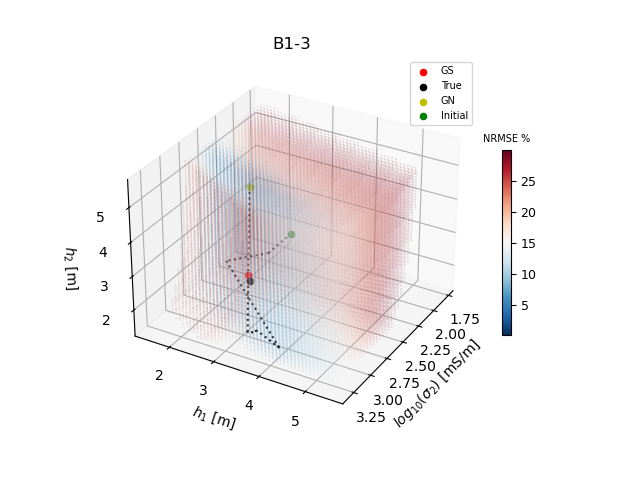

In [22]:
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')

models_err_B1_3_sn = models_err_B1_3.copy()
err_B1_3_sn = err_B1_3.copy()

#index_h1 = (models_err_B1_3_sn[:,0] == model_GS_B1_3[pos,0]) + (models_err_B1_3_sn[:,0] == model_B1_3[pos,0])
#models_err_B1_3_sn = models_err_B1_3_sn[np.where(index_h1)[0]]
#err_B1_3_sn = err_B1_3_sn[np.where(index_h1)[0]]

index_s2 = (models_err_B1_3_sn[:,2] == model_GS_B1_3[pos,2]) + (models_err_B1_3_sn[:,2] == model_B1_3[pos,2])
models_err_B1_3_sn = models_err_B1_3_sn[np.where(index_s2)[0]]
err_B1_3_sn = err_B1_3_sn[np.where(index_s2)[0]]

index_s3 = (models_err_B1_3_sn[:,4] == model_GS_B1_3[pos,4])
models_err_B1_3_sn = models_err_B1_3_sn[np.where(index_s3)[0]]
err_B1_3_sn = err_B1_3_sn[np.where(index_s3)[0]]
 
# defining axes
z = models_err_B1_3_sn[:,1] # h2
x = np.log10(models_err_B1_3_sn[:,3]*1000) # s2
y = models_err_B1_3_sn[:,0] # h1
c = err_B1_3_sn*100
ax.scatter(x, y, z, c = c, s= 0.01, cmap="RdBu_r", )
ax.scatter(np.log10(model_GS_B1_3[pos,3]*1000), model_GS_B1_3[pos,0], model_GS_B1_3[pos,1], c='r', s=20, label='GS')
ax.scatter(np.log10(model_B1_3[pos,3]*1000), model_B1_3[pos,0], model_B1_3[pos,1], c='k', s=20, label='True')
ax.scatter(np.log10(model_Opt_B1_3[pos,3]*1000), model_Opt_B1_3[pos,0], model_Opt_B1_3[pos,1], c='y', s=20, label='GN')
ax.scatter(np.log10(model_ini_2[3]*1000), model_ini_2[0], model_ini_2[1], c='g', s=20, label='Initial')
ax.legend(fontsize=7)
for i in range(len(model_Opt_B1_3_hist)):
    if i >= 1:
        m1 = model_Opt_B1_3_hist[i-1].copy()
        m2 = model_Opt_B1_3_hist[i].copy()
        x = [np.log10(m1[3]*1000), np.log10(m2[3]*1000)]
        y = [m1[0], m2[0]]
        z = [m1[1], m2[1]]
        ax.plot(x,y,z, ':k')

print([x,y,z])
print([np.log10(model_Opt_B1_3[pos,3]*1000), model_Opt_B1_3[pos,0], model_Opt_B1_3[pos,1]])

ax.view_init(30, 30,0)
ax.set_xlabel('$log_{10}(\sigma_2)$ [mS/m]')
ax.set_ylabel('$h_1$ [m]')
ax.set_zlabel('$h_2$ [m]')
clb = fig.colorbar(cb, ax=ax, ticks=[0, 5,10, 15, 20, 25, 30], shrink=0.5)
clb.ax.set_title('NRMSE %', fontsize=7)
clb.ax.tick_params(labelsize=9)
# syntax for plotting
ax.set_title('B1-3')
plt.show()
plt.tight_layout()

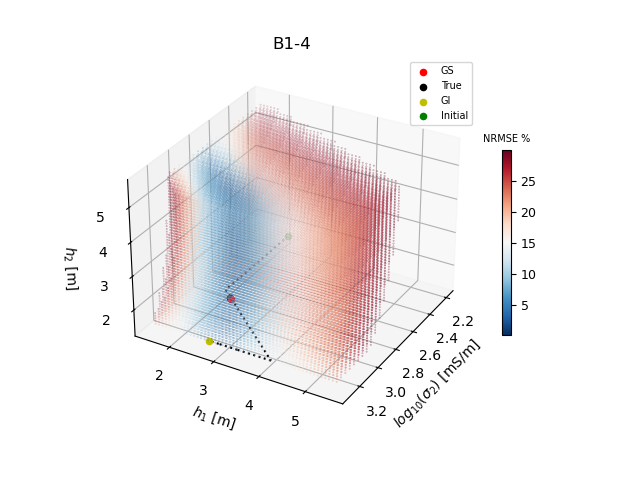

In [23]:
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')

models_err_B1_4_sn = models_err_B1_4.copy()
err_B1_4_sn = err_B1_4.copy()

#index_h1 = (models_err_B1_4_sn[:,0] == model_GS_B1_4[pos,0]) + (models_err_B1_4_sn[:,0] == model_B1_4[pos,0])
#models_err_B1_4_sn = models_err_B1_4_sn[np.where(index_h1)[0]]
#err_B1_4_sn = err_B1_4_sn[np.where(index_h1)[0]]

index_s2 = (models_err_B1_4_sn[:,2] == model_GS_B1_4[pos,2]) + (models_err_B1_4_sn[:,2] == model_B1_4[pos,2])
models_err_B1_4_sn = models_err_B1_4_sn[np.where(index_s2)[0]]
err_B1_4_sn = err_B1_4_sn[np.where(index_s2)[0]]

index_s3 = (models_err_B1_4_sn[:,4] == model_GS_B1_4[pos,4]) + (models_err_B1_4_sn[:,4] == model_B1_4[pos,4])
models_err_B1_4_sn = models_err_B1_4_sn[np.where(index_s3)[0]]
err_B1_4_sn = err_B1_4_sn[np.where(index_s3)[0]]
 
# defining axes
z = models_err_B1_4_sn[:,1] # h2
x = np.log10(models_err_B1_4_sn[:,3]*1000) # s2
y = models_err_B1_4_sn[:,0] # h1
c = err_B1_4_sn*100
ax.scatter(x, y, z, c = c, s= 0.05, cmap="RdBu_r", )
ax.scatter(np.log10(model_GS_B1_4[pos,3]*1000), model_GS_B1_4[pos,0], model_GS_B1_4[pos,1], c='r', s=20, label='GS')
ax.scatter(np.log10(model_B1_4[pos,3]*1000), model_B1_4[pos,0], model_B1_4[pos,1], c='k', s=20, label='True')
ax.scatter(np.log10(model_Opt_B1_4[pos,3]*1000), model_Opt_B1_4[pos,0], model_Opt_B1_4[pos,1], c='y', s=20, label='GI')
ax.scatter(np.log10(model_ini_3[3]*1000), model_ini_3[0], model_ini_3[1], c='g', s=20, label='Initial')
ax.legend(fontsize=7)
for i in range(len(model_Opt_B1_4_hist)):
    if i >= 1:
        m1 = model_Opt_B1_4_hist[i-1]
        m2 = model_Opt_B1_4_hist[i]
        x = np.log10(model_Opt_B1_4_hist[i-1:i+1,3]*1000)
        y = model_Opt_B1_4_hist[i-1:i+1,0]
        z = model_Opt_B1_4_hist[i-1:i+1,1]
        ax.plot(x,y,z, ':k')
ax.view_init(30, 30,0)
ax.set_xlabel('$log_{10}(\sigma_2)$ [mS/m]')
ax.set_ylabel('$h_1$ [m]')
ax.set_zlabel('$h_2$ [m]')
clb = fig.colorbar(cb, ax=ax, ticks=[0, 5,10, 15, 20, 25, 30], shrink=0.5)
clb.ax.set_title('NRMSE %', fontsize=7)
clb.ax.tick_params(labelsize=9)
# syntax for plotting
ax.set_title('B1-4')
plt.show()

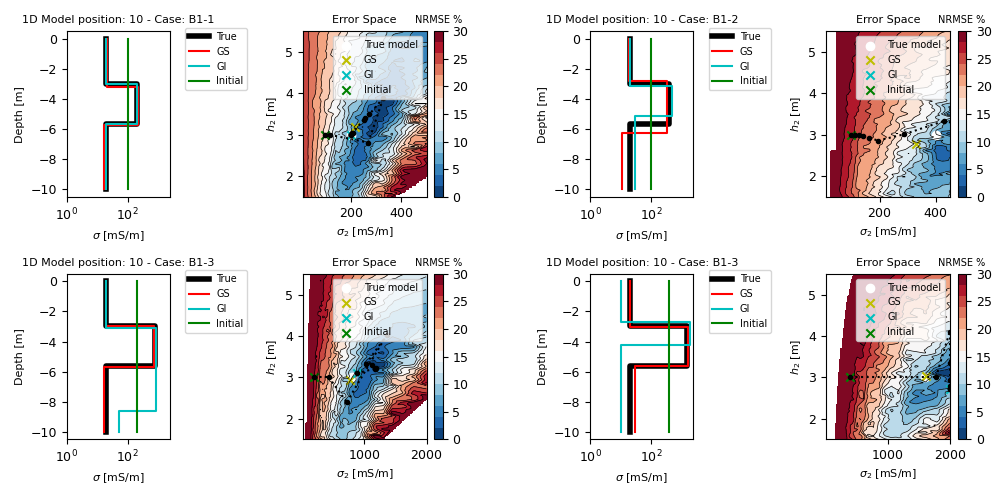

In [19]:
fig, ax = plt.subplots(2,4, figsize=(10,5), gridspec_kw={'width_ratios': [1, 1.5, 1, 1.5]})

PlotErrorSpace(ax[0,0], ax[0,1], model_B1_1[pos], model_GS_B1_1[pos], model_Opt_B1_1[pos], model_ini_1, 
               model_Opt_B1_1_hist, err_B1_1_sn, models_err_B1_1_sn, 
               10, 500, 1.5, 5.5, 
               case='B1-1', method='Error Space', colorbar=True)

PlotErrorSpace(ax[0,2], ax[0,3], model_B1_2[pos], model_GS_B1_2[pos], model_Opt_B1_2[pos], model_ini_1, 
               model_Opt_B1_2_hist, err_B1_2_sn, models_err_B1_2_sn, 
               10, 450, 1.5, 5.5, 
               case='B1-2', method='Error Space', colorbar=True)

PlotErrorSpace(ax[1,0], ax[1,1], model_B1_3[pos], model_GS_B1_3[pos], model_Opt_B1_3[pos], model_ini_2, 
               model_Opt_B1_3_hist, err_B1_3_sn, models_err_B1_3_sn, 
               10, 2000, 1.5, 5.5, 
               case='B1-3', method='Error Space', colorbar=True)

PlotErrorSpace(ax[1,2], ax[1,3], model_B1_4[pos], model_GS_B1_4[pos], model_Opt_B1_4[pos], model_ini_3, 
               model_Opt_B1_4_hist, err_B1_4_sn, models_err_B1_4_sn, 
               10, 2000, 1.5, 5.5, 
               case='B1-3', method='Error Space', colorbar=True)

plt.tight_layout()